In [1]:
from skopt.space import Real
from skopt import gp_minimize, dummy_minimize
from skopt.plots import plot_convergence
import matplotlib.pyplot as plt
import numpy as np
import pygad
from joblib import Parallel, delayed

In [2]:
class SMEnvBayesOpt:
    def __init__(self, snrDb, num_iters, N=2,  M=2, fc=2.4e9, modOrder=16, state_size = 8, action_size = 8, Lt = 3, Lr = 3, kappa=1):
        self.total_bits = np.log2(N) + np.log2(modOrder)
        self.state_size = N * M * 2
        self.action_size = (N + M) * 2
        self.lambda_ = 3e8 / fc
        self.kappa = kappa
        self.d_ant = self.lambda_/2
        self.numTx = N
        self.numRx = M
        self.modOrder = modOrder
        self.num_iters = num_iters
        self.snrDb = snrDb
        self.Lt = Lt
        self.Lr = Lr
        self.max_action = 1.0 * self.d_ant
        self.theta_t = np.random.uniform(0, np.pi, Lt)
        self.phi_t = np.random.uniform(0, np.pi, Lt)
        self.theta_r = np.random.uniform(0, np.pi, Lr)
        self.phi_r = np.random.uniform(0, np.pi, Lr)
        self.reward_range = 0
        var11 = kappa / (kappa + 1)
        sigma_path_response = np.zeros((Lr, Lt), dtype=complex)

        sigma_path_response[0, 0] = np.sqrt(var11) * (np.random.randn() + 1j * np.random.randn())
        varpp = 1 / ((kappa + 1) * (Lr - 1))

        for p in range(1, Lr):
            sigma_path_response[p, p] = np.sqrt(varpp) * (np.random.randn() + 1j * np.random.randn())
        self.sigma_path_response = sigma_path_response

        self.reference_pos = np.random.uniform(-self.max_action, self.max_action, self.action_size)
        self.ref_t_tilde = self.reference_pos[:self.numTx * 2].reshape(2, -1, order='F')
        self.ref_r_tilde = self.reference_pos[self.numTx * 2:].reshape(2, -1, order='F')
        self.allSymbols = self.qamsymbols(modOrder)  # QAM symbols



    def reset(self):

        self.theta_t = np.random.uniform(0, np.pi, self.Lt)
        self.phi_t = np.random.uniform(0, np.pi, self.Lt)
        self.theta_r = np.random.uniform(0, np.pi, self.Lr)
        self.phi_r = np.random.uniform(0, np.pi, self.Lr)
        var11 = self.kappa / (self.kappa + 1)
        sigma_path_response = np.zeros((self.Lr, self.Lt), dtype=complex)

        sigma_path_response[0, 0] = np.sqrt(var11) * (np.random.randn() + 1j * np.random.randn())
        varpp = 1 / ((self.kappa + 1) * (self.Lr - 1))

        for p in range(1, self.Lr):
            sigma_path_response[p, p] = np.sqrt(varpp) * (np.random.randn() + 1j * np.random.randn())
        self.sigma_path_response = sigma_path_response


        observation = self.reference_pos
        return observation;

    def step(self, action):
        # observarion_ : next state, type is numpy array (8,)
        # reward : np.float64(reward)
        # action : numpy array (8,)
        reward = 0
        selected_t_tilde = action[:self.numTx * 2].reshape(2, -1, order='F')
        selected_r_tilde = action[self.numTx * 2:].reshape(2, -1, order='F')
        ber, berMod, berAntenna, numErrors, numBits, H_curr = self.simulate_spatial_modulation_rayleigh_ml(self.numTx, self.numRx, self.modOrder, self.num_iters, self.snrDb, selected_t_tilde, selected_r_tilde, self.Lt, self.Lr, self.lambda_, self.kappa, self.theta_t, self.phi_t, self.theta_r, self.phi_r, self.sigma_path_response)

        observation_ = action

        done = False
        info = (ber, berMod, berAntenna, numErrors, numBits)
        obs_tuple = (observation_, ber, done, info)
        return obs_tuple

    def simulate_spatial_modulation_rayleigh_ml(self,numTx, numRx, modOrder, num_iters, snrDb, t_tilde, r_tilde, Lt, Lr, lambda_, kappa, theta_t, phi_t, theta_r, phi_r, sigma_path_response):

        #TESTED : PASSED
        numBitsPerSymbol = int(np.log2(modOrder) + np.log2(numTx))

        bitsAll = np.array([])
        bitsAntennaAll = np.array([])
        bitsModAll = np.array([])
        rxBitsAll = np.array([])
        rxBitsAntennaAll = np.array([])
        rxBitsModAll = np.array([])

        allSymbols = self.qamsymbols(modOrder)  # QAM symbols
        allBitsMod = np.array([list(map(int, list(format(i, f'0{int(np.log2(modOrder))}b')))) for i in range(modOrder)])
        H = self.get_channel(numTx, numRx, t_tilde, r_tilde, Lt, Lr, lambda_, kappa, theta_t, phi_t, theta_r, phi_r, sigma_path_response)
        bits = np.random.randint(0, 2, (num_iters, numBitsPerSymbol))

        # Split bits into bitsAntenna and bitsMod
        bitsAntenna = bits[:, :int(np.log2(numTx))]
        bitsMod = bits[:, int(np.log2(numTx)):]

        # Convert bits to indices
        bitsAntenna_powers = 2 ** np.arange(bitsAntenna.shape[1]-1, -1, -1)
        antennaIndex = bitsAntenna.dot(bitsAntenna_powers).astype(int)

        bitsMod_powers = 2 ** np.arange(bitsMod.shape[1]-1, -1, -1)
        symbolIndex = bitsMod.dot(bitsMod_powers).astype(int)

        # Map indices to symbols
        symbols = allSymbols[symbolIndex]

        # Create txSignal array
        txSignal = np.zeros((num_iters, numTx), dtype=complex)
        txSignal[np.arange(num_iters), antennaIndex] = symbols

        # Compute rxSignal
        rxSignal = txSignal @ H.T  # Shape: (num_iters, numRx)

        # Add noise to rxSignal
        noisePower = 10 ** (-snrDb / 10)
        noise = np.sqrt(noisePower / 2) * (np.random.randn(num_iters, numRx) + 1j * np.random.randn(num_iters, numRx))
        rxSignal += noise

        # Initialize arrays to store received bits
        rxBitsAll = []
        rxBitsAntennaAll = []
        rxBitsModAll = []

        # Process rxSignal to get received bits
        for i in range(num_iters):
            rxBits, rxBitsMod, rxBitsAntenna = self.ml_detect(
                rxSignal[i],
                H,
                numTx,
                modOrder,
                allSymbols,
                allBitsMod
            )
            rxBitsAll.append(rxBits)
            rxBitsAntennaAll.append(rxBitsAntenna)
            rxBitsModAll.append(rxBitsMod)

        # Convert lists to arrays
        rxBitsAll = np.concatenate(rxBitsAll)
        rxBitsAntennaAll = np.concatenate(rxBitsAntennaAll)
        rxBitsModAll = np.concatenate(rxBitsModAll)

        # Original bits (transmitted bits)
        bitsAll = bits.flatten()
        bitsAntennaAll = bitsAntenna.flatten()
        bitsModAll = bitsMod.flatten()

        numErrors = np.sum(bitsAll != rxBitsAll)
        numErrorsMod = np.sum(bitsModAll != rxBitsModAll)
        numErrorsAntenna = np.sum(bitsAntennaAll != rxBitsAntennaAll)

        numBits = len(bitsAll)
        numBitsMod = len(bitsModAll)
        numBitsAntenna = len(bitsAntennaAll)

        ber = numErrors / numBits
        berMod = numErrorsMod / numBitsMod
        berAntenna = numErrorsAntenna / numBitsAntenna

        #print(f'BER: {ber}')
        #print(f'Total Errors: {numErrors} out of {numBits} bits')

        return ber, berMod, berAntenna, numErrors, numBits, H

    def get_channel(self, N, M, t_tilde, r_tilde, Lt, Lr, lambda_, kappa, theta_t, phi_t, theta_r, phi_r, sigma_path_response):
        # TESTED : PASSED
        rho_t = np.zeros((Lt, N), dtype=float)
        phase_diff_t = np.zeros((Lt, N), dtype=float)
        G = np.zeros((Lt, N), dtype=complex)
        for t in range(N):
            g = np.zeros(Lt, dtype=complex)
            for p in range(Lt):
                x_t = t_tilde[0, t]
                y_t = t_tilde[1, t]

                thetaP_t = theta_t[p]
                phiP_t = phi_t[p]

                rho_t[p, t] = (x_t * np.sin(thetaP_t) * np.cos(phiP_t) + y_t * np.cos(thetaP_t)).item(0)
                phase_diff_t[p, t] = 2 * np.pi * rho_t[p, t] / lambda_

                g[p] = np.exp(1j * phase_diff_t[p, t])

            G[:, t] = np.transpose(g)

        rho_r = np.zeros((Lr, M), dtype=float)
        phase_diff_r = np.zeros((Lr, M), dtype=float)
        F = np.zeros((Lr, M), dtype=complex)
        for r in range(M):
            f = np.zeros(Lr, dtype=complex)
            for q in range(Lr):
                x_r = r_tilde[0, r]
                y_r = r_tilde[1, r]

                thetaQ_r = theta_r[q]
                phiQ_r = phi_r[q]

                rho_r[q, r] = (x_r * np.sin(thetaQ_r) * np.cos(phiQ_r) + y_r * np.cos(thetaQ_r)).item(0)
                phase_diff_r[q, r] = 2 * np.pi * rho_r[q, r] / lambda_

                f[q] = np.exp(1j * phase_diff_r[q, r])

            F[:, r] = np.transpose(f)

        H = np.conjugate(np.transpose(F)) @ sigma_path_response @ G
        return H

    def ml_detect(self, rxSignal, H, numTx, modOrder, allSymbols, allBitsMod):
        # Number of possible combinations
        numCombinations = numTx * modOrder

        # Generate all possible antenna indices and symbol indices
        txIdxs = np.repeat(np.arange(numTx), modOrder)
        symIdxs = np.tile(np.arange(modOrder), numTx)

        # Create test signals for all combinations
        testSignals = np.zeros((numCombinations, numTx), dtype=complex)
        testSignals[np.arange(numCombinations), txIdxs] = allSymbols[symIdxs]

        # Compute estimated received signals for all combinations
        estimatedRxSignals = testSignals @ H.T  # Shape: (numCombinations, numRx)

        # Compute distances between the received signal and all estimated signals
        differences = estimatedRxSignals - rxSignal[np.newaxis, :]
        distances_squared = np.sum(np.abs(differences) ** 2, axis=1)

        # Find the combination with the minimum distance
        min_idx = np.argmin(distances_squared)
        best_txIdx = txIdxs[min_idx]
        best_symIdx = symIdxs[min_idx]

        # Retrieve the bits corresponding to the detected antenna index and symbol
        rxBitsMod = allBitsMod[best_symIdx]
        bits_per_antenna = int(np.log2(numTx))
        rxBitsAntenna = np.array(list(np.binary_repr(best_txIdx, width=bits_per_antenna)), dtype=int)
        rxBits = np.concatenate((rxBitsAntenna, rxBitsMod))

        return rxBits, rxBitsMod, rxBitsAntenna
    def qamsymbols(self, n):
        # returns exactly MATLAB: qammod(0:modOrder-1, modOrder, 'UnitAveragePower', true)
        if n == 16:
            return np.array([-0.948683298050514 + 1j*0.948683298050514,
            -0.948683298050514 + 1j*0.316227766016838,	-0.948683298050514 - 1j*0.948683298050514,	-0.948683298050514 - 1j*0.316227766016838	,
            -0.316227766016838 + 1j*0.948683298050514,	-0.316227766016838 + 1j*0.316227766016838,	-0.316227766016838 - 1j*0.948683298050514,
            -0.316227766016838 - 1j*0.316227766016838,	0.948683298050514 + 1j*0.948683298050514,	0.948683298050514 + 1j*0.316227766016838	,
            0.948683298050514 - 1j*0.948683298050514,	0.948683298050514 - 1j*0.316227766016838,	0.316227766016838 + 1j*0.948683298050514	,
            0.316227766016838 + 1j*0.316227766016838,	0.316227766016838 - 1j*0.948683298050514,	0.316227766016838 - 1j*0.316227766016838])
        else:
            raise ValueError("Not available")

    def get_min_ed(self, H, allSymbols, HcolIndices):
        H_dist_arr = np.zeros((HcolIndices.shape[0], len(allSymbols)**2))

        for k in range(HcolIndices.shape[0]):
            index = 0
            for s1 in range(len(allSymbols)):
                for s2 in range(len(allSymbols)):
                    # Calculate the norm between combinations of h1*s1 and h2*s2
                    H_dist_arr[k, index] = np.linalg.norm((H[:, HcolIndices[k, 0]-1] * allSymbols[s1]) - (H[:, HcolIndices[k, 1]-1] * allSymbols[s2]))
                    index += 1

        decision_metric = np.min(H_dist_arr[H_dist_arr != 0])
        return decision_metric

In [3]:
def objective_ga(ga_instance, solution, solution_idx):
    action = np.array(solution)
    obs, ber, done, info = env.step(action)
    return -ber # Genetic algorithm maximizes the objective (fitness) function
    
def objective_dummy(params):
    """Objective function to be minimized."""
    action = np.array(params)
    obs, ber, done, info = env.step(action)
    return ber

def create_search_space(env):
    search_space = [
        Real(-env.max_action, env.max_action, name=f'x{i+1}')
        for i in range(env.action_size)
    ]
    return search_space

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import pygad

# Number of independent GA runs per SNR
N_CHANNEL_RUNS = 1000

# SNR values and corresponding iteration counts
SNR_VALS   = [0, 12, 20]
#NUM_ITERS  = [int(5e3), int(8e3), int(1e4), int(2e4), int(3e4), int(5e4)]
NUM_ITERS  = [int(5e3), int(2e4), int(5e4)]
# To store the mean BER from GA at each SNR
ber_plot_ga = []

def run_optim_single(env, search_space):
    env.reset()
    # configure and run GA
    ga = pygad.GA(
        num_generations=10,
        num_parents_mating=5,
        fitness_func=objective_ga,
        sol_per_pop=10,
        num_genes=env.action_size,
        init_range_low=-env.max_action,
        init_range_high=env.max_action,
        mutation_percent_genes=20
    )
    ga.run()
    # grab best-fitness per generation
    fitness_history = ga.best_solutions_fitness
    return fitness_history

for idx, snr_db in enumerate(SNR_VALS):
    # build environment and search space
    env = SMEnvBayesOpt(snrDb=snr_db, num_iters=NUM_ITERS[idx])
    search_space = create_search_space(env)

    print(f"\nRunning GA convergence at {snr_db} dB...")

    # Run the GA N_CHANNEL_RUNS times in parallel
    all_histories = Parallel(n_jobs=32)(
        delayed(run_optim_single)(env, search_space)
        for _ in range(N_CHANNEL_RUNS)
    )
    # Convert to array: shape (runs, generations)
    hist_array = np.array(all_histories)

    # Compute average best-fitness per generation
    avg_history = hist_array.mean(axis=0)
    # Plot all convergence curves + the average
    plt.figure(figsize=(8, 6))
    gens = np.arange(1, hist_array.shape[1] + 1)

    # Save the array to a .npy file
    np.save(f"run_hist_array_{snr_db}.npy", hist_array)
print("\nAll mean GA BER values:", ber_plot_ga)


Running GA convergence at 0 dB...

Running GA convergence at 12 dB...

Running GA convergence at 20 dB...

All mean GA BER values: []


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

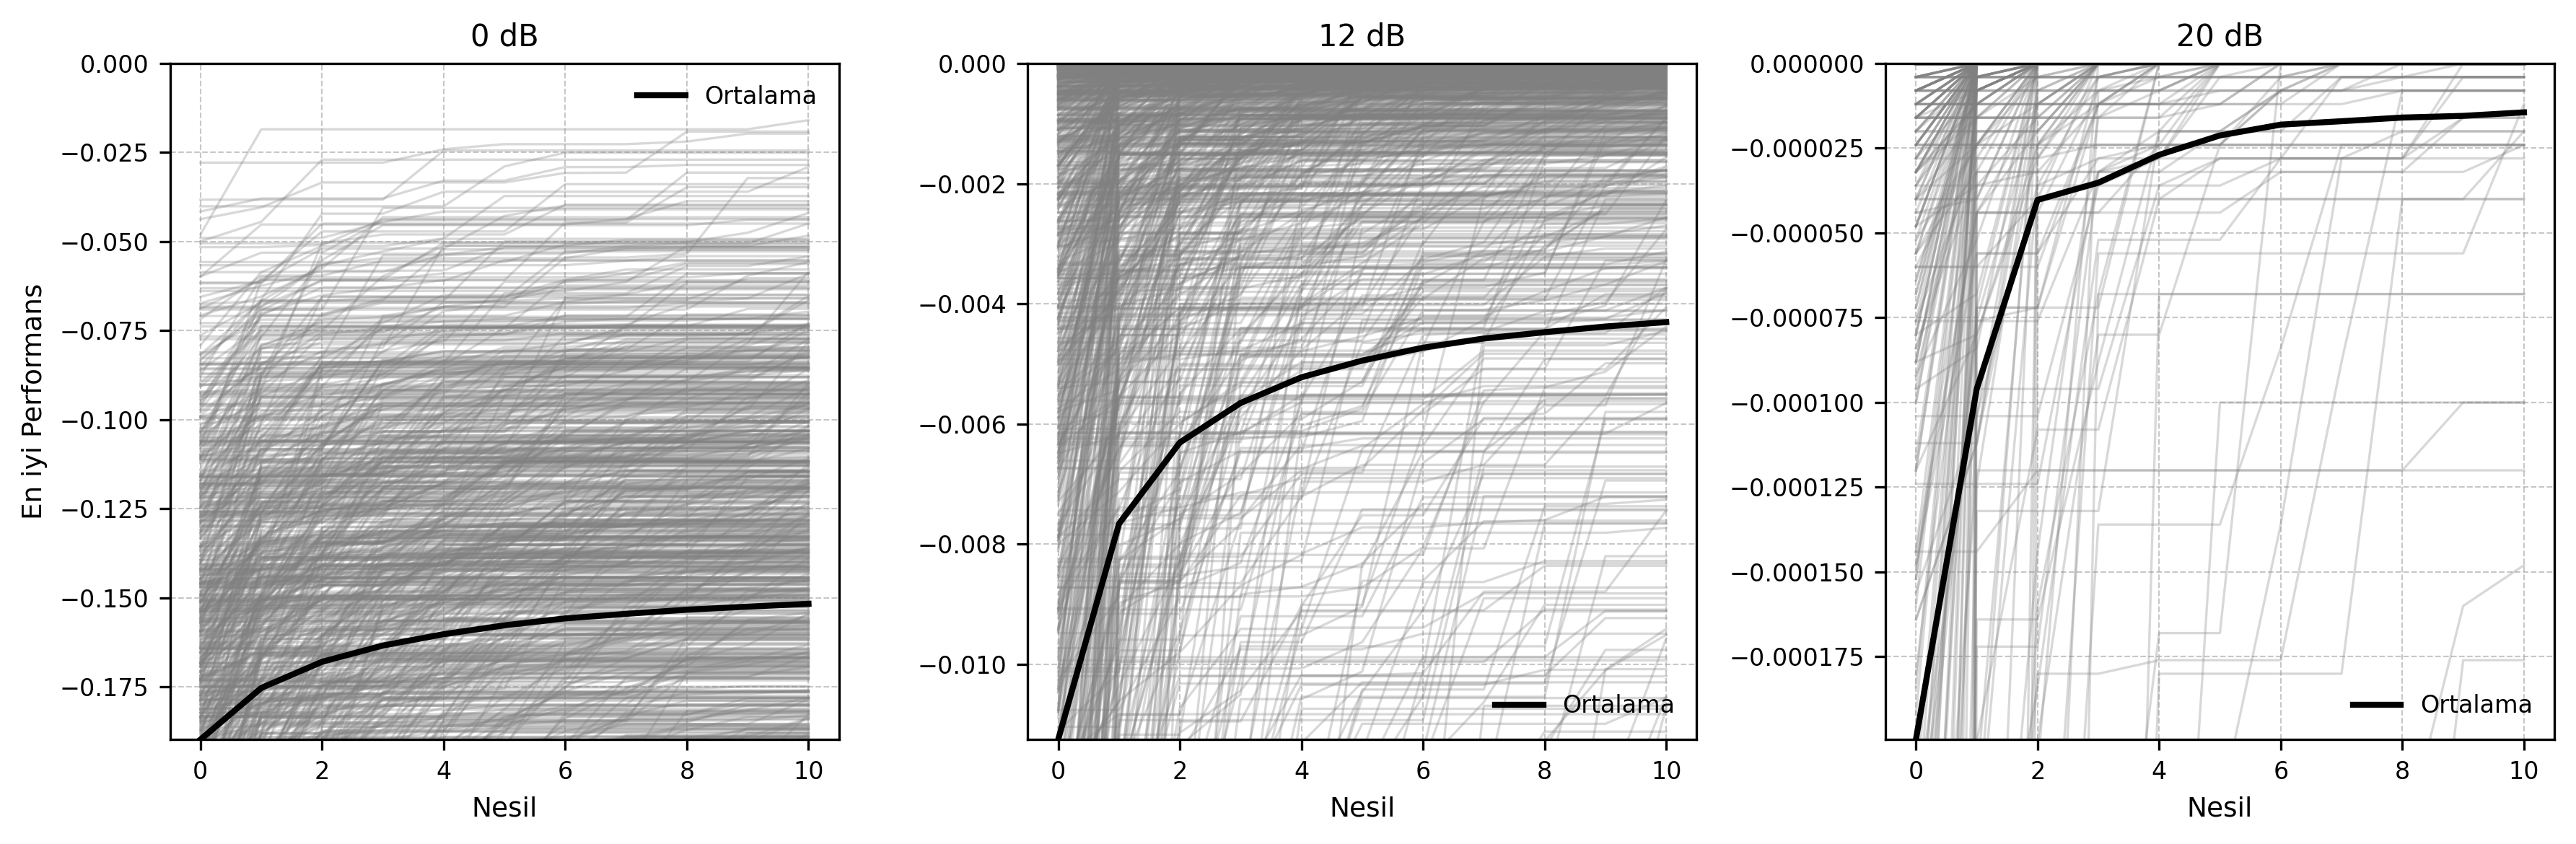

In [6]:
# Define SNRs and filenames
snr_levels = [0, 12, 20]
file_template = "run_hist_array_{}.npy"

# Create subplots for each SNR
fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=300)

for idx, snr_db in enumerate(snr_levels):
    # Load data
    file_name = file_template.format(snr_db)
    hist_array = np.load(file_name, allow_pickle=True)

    # Compute average best fitness per generation
    avg_history = np.mean(hist_array, axis=0)
    gens = np.arange(len(avg_history))

    # Clip to avoid extreme low values (optional, not necessary for plot)
    # hist_array = np.clip(hist_array, 1e-8, None)
    # avg_history = np.clip(avg_history, 1e-8, None)

    ax = axes[idx]

    # Plot individual runs (semi-transparent)
    for run_hist in hist_array:
        ax.plot(gens, run_hist, alpha=0.3, linewidth=0.8, color='gray')

    # Plot average curve
    ax.plot(gens, avg_history, linewidth=2.0, color='black', label='Ortalama')

    # Set y-axis limit based on minimum of average curve
    y_min = np.min(avg_history)
    y_max = np.max(avg_history)
    ax.set_ylim([y_min,0])

    # Titles and labels
    ax.set_title(f"{snr_db} dB", fontsize=10)
    ax.set_xlabel("Nesil", fontsize=9)
    if idx == 0:
        ax.set_ylabel("En iyi Performans", fontsize=9)

    # Styling
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.legend(fontsize=8, frameon=False)
    ax.tick_params(labelsize=8)

# Adjust layout and save
plt.tight_layout()
plt.savefig("ga_convergence_limited_yaxis.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [8]:
# Define SNRs and filenames
snr_levels = [0, 12, 20]
file_template = "run_hist_array_{}.npy"
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"], # Or another font like "Times New Roman"
    "font.size": 12
})
# Create subplots for each SNR
fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=300)

for idx, snr_db in enumerate(snr_levels):
    # Load data
    file_name = file_template.format(snr_db)
    hist_array = np.load(file_name, allow_pickle=True)

    # Compute average best fitness per generation
    avg_history = np.mean(hist_array, axis=0)
    gens = np.arange(len(avg_history))

    # Clip to avoid extreme low values (optional, not necessary for plot)
    # hist_array = np.clip(hist_array, 1e-8, None)
    # avg_history = np.clip(avg_history, 1e-8, None)

    ax = axes[idx]

    # Plot individual runs (semi-transparent)
    for run_hist in hist_array:
        ax.plot(gens, run_hist, alpha=0.3, linewidth=0.8, color='gray')

    # Plot average curve
    ax.plot(gens, avg_history, linewidth=2.0, color='black', label='Average')

    # Set y-axis limit based on minimum of average curve
    y_min = np.min(avg_history)
    y_max = np.max(avg_history)
    ax.set_ylim([y_min,0])

    # Titles and labels
    ax.set_title(f"{snr_db} dB", fontsize=10)
    ax.set_xlabel("Generation", fontsize=9)
    if idx == 0:
        ax.set_ylabel("Best Fitness", fontsize=9)

    # Styling
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.legend(fontsize=8, frameon=False)
    ax.tick_params(labelsize=8)

# Adjust layout and save
plt.tight_layout()
plt.savefig("en_ga_convergence_limited_yaxis.pdf", format='pdf', bbox_inches='tight')
plt.show()

RuntimeError: Failed to process string with tex because latex could not be found

Error in callback <function _draw_all_if_interactive at 0x79cc8499eb60> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 3600x1200 with 3 Axes>